In [1]:
#From the pyticles outputs (64 nc files corresponding to 101 days of particles released)
#We create 64 nc files that containt all the pdf for corresponding period

In [4]:
#Load packages

from netCDF4 import Dataset
import numpy as np
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import sys
import netCDF4 as nc4

sys.path.append("/home2/datahome/tpicard/python/Python_Modules_p3_pyticles/")

from Modules import *
from Modules_gula import *

In [5]:
# Function that take all the particules positions px and py 
# (pxcenter,pycenter) is the center of a sub-patch that containt 36 particles 
# index_start is generally 0, 20 or 40 and correspond to the number of time step after the starting period of simu
# Return a list of index that correspond to the particles located inside the sub-patch

def spatial_filter(px,py,pxcenter,pycenter,index_start):
    
    #On garde que le premier pas de temps
    px = px[0,0:10201]
    py = py[0,0:10201]
    
    a = np.where(abs(px - pxcenter) <= 3,1,0) # Filter on lon
    b = np.where(abs(py - pycenter) <= 3,1,0) # Filter on lat
    c = np.multiply(a,b) 
    index = np.argwhere(c == 1) # Combinason of both filter
    #print(index.shape)
    index_tot = []
    
    for i in range(index_start,index_start+20): # We consider all the particles released for a 10 days perdiod
        index_temp = index + 10201*(i)
        index_tot.append(index_temp)
        
    return np.array(index_tot).ravel()

# Compute ouputs

In [9]:
# Take a date among the 64 period
# Return all the 108 independant pdf during this period

def compute_outputs(time_end):
    
    # 36 : number of sub-pathes 
    # 3 : number of time step considered in a 101 days period
    # 80x80 : Spatial resolution of the pdf
    
    jpdf_list = np.zeros((36,3,1,80,80))
    
    #List of the 36 sub-patches centers 
    ic_all_list = np.linspace(1520.5,1610.5,6)
    jc_all_list = np.linspace(569.5,659.5,6)
    
    ########################
    # Choose the folder
    ########################

    folder = '/home2/datawork/tpicard/Pyticles/OUTPUTS/'
    
    tpas_time_end = int(time_end/101)
    tpas = tpas_time_end
    correction_tpas = int(tpas/20)*20
    date1 = 100*tpas + correction_tpas
    date2 = 101*tpas

    file = folder + '7YEARS/apero_trap1000m_sed50_2000dx_100nx_{0:06}_56_{1:04}.nc'.format(date2,date1)

    #Load data
    nc = Dataset(file, 'r')
    px = nc.variables['px']
    py = nc.variables['py']
    pdepth = np.asfortranarray(nc.variables['pdepth'])

    dx, dy = 1.979, 1.979 #grid size

    print('File for date start ={0} is building...'.format(time_end-101))
    
    # Create pdf
    for dt in range(0,3):
        i=0
        for ic in ic_all_list:
            for jc in jc_all_list:
            

                #Load data for background
                index_start = 20*dt #Choose 0, 20 or 40

                x_disp = []
                y_disp = []
                #temp = []

                index = spatial_filter(px,py,ic,jc,index_start) #Filtre spatial haut droite

                npart_trap = index.size
                count = 0

                for ipart in index:
                    index_realtime = np.where( pdepth[:,ipart] != 0 )[0] # find the period when particles are released
                    if ipart%100000 ==0:
                        print('ipart = ' +str(ipart))

                    if index_realtime.size != 0:# check if particles are released
                        pdepth_tmp = pdepth[index_realtime,ipart]
                        index_200m = np.argmax(pdepth_tmp > -200.)


                        if index_200m != 0: # particles have reached upper -200 m  
                            count = count+1
                            index_200m = np.round(index_realtime[index_200m])

                            x_disp.append( (px[index_200m, ipart]-px[index_realtime[0], ipart] )*dx ) #to have a centered scheme
                            y_disp.append( (py[index_200m, ipart]-py[index_realtime[0], ipart] )*dy )


                xband, yband = np.linspace(-400,400,81), np.linspace(-400,400,81)
                binbox = (xband[1]-xband[0])*(yband[1]-yband[0])
                X, Y = x_disp, y_disp
                H,xedges,yedges = np.histogram2d(X,Y,bins=[xband,yband])
                N = len(X)
                jpdf = 1/(binbox*N)*H
                jpdf_list[i,dt,0,:,:] = jpdf
                i =i+1
                
    return(jpdf_list)

# Create the nc file

In [10]:
#Put all the pdf for a 101 days period inside a nc_file
#zdim is created for covolutionnal operation

def Create_nc_file(time_start):

    #vrt,temp,ssh,u,v,pdf = compute_variable_time_dim(time_start)
    time_end = time_start+101
    jpdf = compute_outputs(time_end)
    
    nc_name = 'output_date_{0:06}.nc'.format(time_start)
    
    #creating the file
    nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/OUTPUTS/PDF/{0}'.format(nc_name),'w')

    #Dimensions used
    nc.createDimension('pdfsize', 80)
    nc.createDimension('nb_patch', 36)
    nc.createDimension('zdim', 1)
    nc.createDimension('dt', 3)
    
    #Variables used
    nc.createVariable('pdf', 'f4', ('nb_patch','dt','zdim','pdfsize', 'pdfsize'))
    nc.variables['pdf'][:] = jpdf
    
    nc.close()
    
    print('File for date ={0} is done'.format(time_start))

# Create all the pdf inside ncfile

In [13]:
# Loop for all the period (from 0 to 64)

for dt in range(3,4,1):
    time_start = dt*101
    Create_nc_file(time_start)


File for date start =303 is building...
ipart = 0
ipart = 400000
File for date =303 is done


In [12]:
nc.close()

NameError: name 'nc' is not defined

# Test pdf created

In [ ]:
ncfile = 'output_date_000202.nc'
nc = nc4.Dataset('/home2/datawork/tpicard/Pyticles/OUTPUTS/PDF/{0}'.format(ncfile),'r')

pdf = np.asfortranarray(nc.variables['pdf'])
nc.close()


In [61]:
pdf.shape

(36, 3, 1, 80, 80)

<ipython-input-67-211595b19987>:9: UserWarning: Log scale: values of z <= 0 have been masked
  ctf = plt.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), pdf[35,2,0,:,:].T,  levels, norm=norm, cmap=cmap, extend='both')


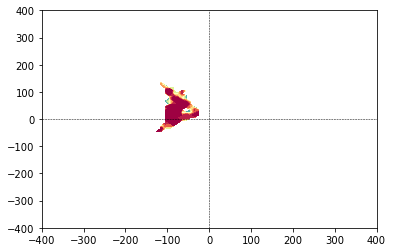

In [67]:
xband, yband = np.linspace(-400,400,81), np.linspace(-400,400,81)

plt.figure()
cmap = 'Spectral_r'
levels=np.logspace(-5, -4, 10)
norm= colors.LogNorm(vmin=1e-5, vmax=1e-4)
ctf = plt.contourf(0.5*(xband[:-1]+xband[1:]), 0.5*(yband[:-1]+yband[1:]), pdf[35,2,0,:,:].T,  levels, norm=norm, cmap=cmap, extend='both')
#cb.set_ticks([1e-6, 1e-5, 1e-4])
#cb.ax.tick_params(labelsize='large')
plt.xlim([-400,400])
plt.ylim([-400,400])

plt.axvline(x=0,color='black',linestyle='--',linewidth=0.5)
plt.axhline(y=0,color='black',linestyle='--',linewidth=0.5)